# Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which this Colab will make heavy use of.

In [ ]:
import tensorflow as tf
import joblib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# TODO: Download the Flowers Dataset using TensorFlow Datasets

In [ ]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The images in the Flowers dataset are not all the same size.

In [ ]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches


In [ ]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Create a Feature Extractor


In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 12s 122ms/step - loss: 0.1761 - accuracy: 0.9521 - val_loss: 0.2998 - val_accuracy: 0.8992
Epoch 2/6
81/81 [==============================] - 9s 109ms/step - loss: 0.1502 - accuracy: 0.9626 - val_loss: 0.2963 - val_accuracy: 0.8974
Epoch 3/6
81/81 [==============================] - 9s 110ms/step - loss: 0.1336 - accuracy: 0.9669 - val_loss: 0.2867 - val_accuracy: 0.9037
Epoch 4/6
81/81 [==============================] - 9s 109ms/step - loss: 0.1139 - accuracy: 0.9766 - val_loss: 0.2874 - val_accuracy: 0.9001
Epoch 5/6
81/81 [==============================] - 9s 109ms/step - loss: 0.1001 - accuracy: 0.9774 - val_loss: 0.2888 - val_accuracy: 0.9037
Epoch 6/6
81/81 [==============================] - 9s 109ms/step - loss: 0.0904 - accuracy: 0.9825 - val_loss: 0.2829 - val_accuracy: 0.9028


In [ ]:
model.save('my_model')

In [ ]:
!zip -r my_model.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/keras_metadata.pb (deflated 80%)
  adding: content/my_model/saved_model.pb (deflated 92%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/my_model/variables/variables.index (deflated 78%)


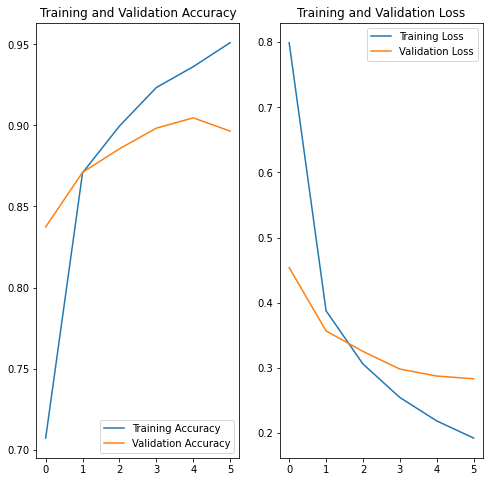

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#  Check Predictions


In [ ]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### Create an Image Batch and Make Predictions


In [ ]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['dandelion' 'daisy' 'daisy' 'daisy' 'sunflowers' 'tulips' 'roses'
 'sunflowers' 'daisy' 'dandelion' 'sunflowers' 'dandelion' 'tulips'
 'tulips' 'tulips' 'roses' 'tulips' 'sunflowers' 'roses' 'dandelion'
 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'tulips' 'roses' 'tulips'
 'daisy' 'dandelion' 'roses' 'sunflowers' 'sunflowers']


In [ ]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 1 1 1 0 2 4 3 1 0 3 0 2 2 2 4 2 3 4 0 0 2 3 0 2 2 2 1 0 4 3 3]
Predicted labels:  [0 1 1 1 3 2 4 3 1 0 3 0 2 2 2 4 2 3 4 0 0 2 3 0 2 4 2 1 0 4 3 3]


# Plot Model Predictions

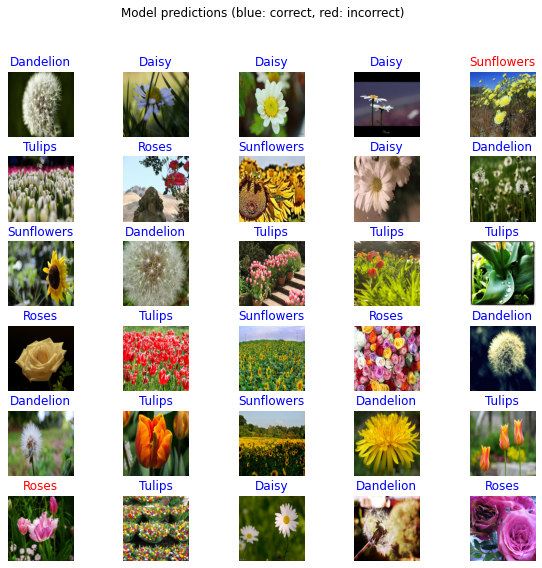

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# TODO: Perform Transfer Learning with the Inception Model

(https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) 

In [ ]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 23s 195ms/step - loss: 0.7431 - accuracy: 0.7256 - val_loss: 0.4664 - val_accuracy: 0.8538
Epoch 2/6
81/81 [==============================] - 13s 164ms/step - loss: 0.3934 - accuracy: 0.8762 - val_loss: 0.3710 - val_accuracy: 0.8819
Epoch 3/6
81/81 [==============================] - 13s 160ms/step - loss: 0.3132 - accuracy: 0.9007 - val_loss: 0.3395 - val_accuracy: 0.8792
Epoch 4/6
81/81 [==============================] - 13s 161ms/step - loss: 0.2666 - accuracy: 0.9132 - val_loss: 0.3073 - val_accuracy: 0.8965
Epoch 5/6
81/81 [==============================] - 13s 161ms/step - loss: 0.2320 - accuracy: 0.9307 - val_loss: 0.2948 - val_accuracy: 0.8992
Epoch 6/6
81/81 [==============================] - 13s 163ms/step - loss: 0.2050 - accuracy: 0.9401 - val_loss: 0.2921 - val_accuracy: 0.9010


## the second transfer model performs better on the data by just 1 %